In [6]:
from google.colab import drive
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow_datasets as tfds
import PIL
from IPython.display import clear_output


Mounted at /content/drive/
/content/drive/MyDrive/ORIGAdatasetImages/RIGA 200 Images/


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ORIGAdatasetImages/RIGA 200 Images/'

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


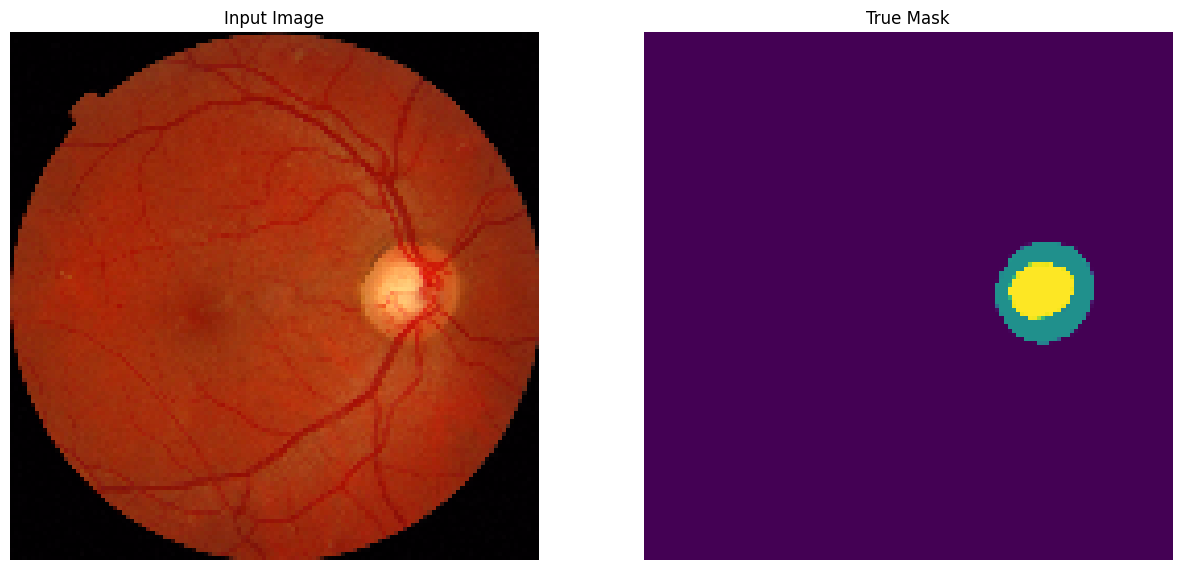

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 128, 128, 16)         448       ['input_3[0][0]']             
                                                                                                  
 conv2d_31 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_30[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 16)           0         ['conv2d_31[0][0]']           
 g2D)                                                                                       

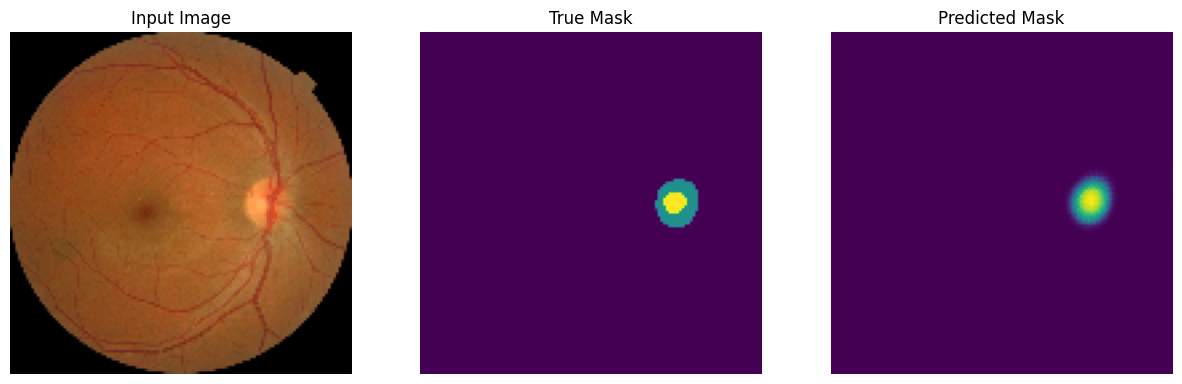

In [5]:
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the paths to the images and masks
images_path = 'drive/MyDrive/ORIGADatasetImages/riga/IMG/'
tif_masks_path = 'drive/MyDrive/ORIGADatasetImages/riga/tifMASK/'
jpg_masks_path = 'drive/MyDrive/ORIGADatasetImages/riga/jpgMASK/'

# Ensure the jpgMASK directory exists
os.makedirs(jpg_masks_path, exist_ok=True)

# Convert .tif masks to .jpg
for filename in os.listdir(tif_masks_path):
    if filename.endswith(".tif"):
        mask_path = os.path.join(tif_masks_path, filename)
        mask = Image.open(mask_path)
        jpg_filename = filename.replace('.tif', '.jpg')
        mask.save(os.path.join(jpg_masks_path, jpg_filename))

# Get the list of image and mask files
image_files = sorted([os.path.join(images_path, fname) for fname in os.listdir(images_path) if fname.endswith(".png")])
mask_files = sorted([os.path.join(jpg_masks_path, fname) for fname in os.listdir(jpg_masks_path) if fname.endswith(".jpg")])

# Ensure there are images and masks
assert len(image_files) == len(mask_files), "Mismatch between number of images and masks"

# Constants
BATCH_SIZE = 8
BUFFER_SIZE = 1000
EPOCHS = 80  # Increased epochs for better training
STEPS_PER_EPOCH = len(image_files) // BATCH_SIZE
IMG_SIZE = (128, 128)

# Normalize function
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0  # Changed to float32
    return input_image, input_mask

# Load image and mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)

    image, mask = normalize(image, mask)
    return image, mask

# Load dataset
def load_dataset(image_files, mask_files, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

    def process_path(image_path, mask_path):
        image, mask = load_image_and_mask(image_path, mask_path)
        if augment:
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)
            if tf.random.uniform(()) > 0.5:
                image = tf.image.adjust_brightness(image, delta=0.1)
            if tf.random.uniform(()) > 0.5:
                image = tf.image.adjust_contrast(image, contrast_factor=1.1)
        return image, mask

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Split dataset
train_size = int(0.8 * len(image_files))
test_size = len(image_files) - train_size

train_dataset = load_dataset(image_files[:train_size], mask_files[:train_size], augment=True)
test_dataset = load_dataset(image_files[train_size:], mask_files[train_size:])

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Display function
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
    display_list = [sample_image, sample_mask]
    display_images(display_list)

# Define U-Net model
from tensorflow.keras import layers, models

def simple_unet_model(input_size=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_size)

    # Encoder: Down-sampling
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder: Up-sampling
    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=[inputs], outputs=[conv8])

    return model

model = simple_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

def check_for_nans(dataset):
    for image, mask in dataset.take(1):
        if tf.reduce_any(tf.math.is_nan(image)) or tf.reduce_any(tf.math.is_nan(mask)):
            print("NaNs found in the dataset")
        else:
            print("No NaNs in the dataset")

check_for_nans(train_dataset)
check_for_nans(test_dataset)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=test_dataset, callbacks=[early_stopping])

# Display function with predictions
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
    pred_mask = model.predict(tf.expand_dims(sample_image, axis=0))[0]
    display_list = [sample_image, sample_mask, pred_mask]
    display_images(display_list)

CDR Ratio calculation from an image

In [57]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [73]:
image = cv.imread("/content/drive/MyDrive/ORIGADatasetImages/riga/MASK/13.tif")
height, width, _ = image.shape

imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 250, 255, cv.THRESH_BINARY)

contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

diameter_cup = 0
diameter_cup_contour = None

for idx, contour in enumerate(contours):
  (x, y), radius = cv.minEnclosingCircle(contour)
  diameter = 2 * radius
  if diameter > diameter_cup:
      diameter_cup = diameter
      diameter_cup_contour = contour


imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

diameter_disk = 0
diameter_disk_contour = None

for idx, contour in enumerate(contours):
  (x, y), radius = cv.minEnclosingCircle(contour)
  diameter = 2 * radius
  if diameter > diameter_disk:
      diameter_disk = diameter
      diameter_disk_contour = contour


print("Diameter Cup = ", diameter_cup)
print("Diameter Disk = ", diameter_disk)

print("Diameter Ratio = ", diameter_cup/diameter_disk)
if diameter_cup/diameter_disk >= 0.6:
  print("Gulacoma might be present")
else:
  print("Gulacoma is not present")


# cv2_imshow(image)

Diameter Cup =  173.03265380859375
Diameter Disk =  264.4997253417969
Diameter Ratio =  0.6541884063773382
Gulacoma might be present


In [ ]:
import os
from PIL import Image
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your trained model loaded
model = simple_unet_model()  # Load your U-Net model structure
model.load_weights('path_to_your_trained_model.h5')  # Load your trained weights

# Define the function
def predict_and_calculate_cdr(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((128, 128))
    image = np.array(image)
    input_image = tf.cast(image, tf.float32) / 255.0
    input_image = tf.expand_dims(input_image, axis=0)

    # Predict the mask
    pred_mask = model.predict(input_image)[0]

    # Resize predicted mask to original image size
    pred_mask_resized = cv.resize(pred_mask, (image.shape[1], image.shape[0]))
    pred_mask_resized = (pred_mask_resized > 0.5).astype(np.uint8) * 255  # Binarize the mask

    # Save the predicted mask as an image (optional)
    pred_mask_image = Image.fromarray(pred_mask_resized)
    pred_mask_image.save('predicted_mask.jpg')

    # Calculate CDR from the predicted mask
    imgray = pred_mask_resized
    ret, thresh = cv.threshold(imgray, 250, 255, cv.THRESH_BINARY)

    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    diameter_cup = 0
    diameter_cup_contour = None

    for idx, contour in enumerate(contours):
        (x, y), radius = cv.minEnclosingCircle(contour)
        diameter = 2 * radius
        if diameter > diameter_cup:
            diameter_cup = diameter
            diameter_cup_contour = contour

    ret, thresh = cv.threshold(imgray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    diameter_disk = 0
    diameter_disk_contour = None

    for idx, contour in enumerate(contours):
        (x, y), radius = cv.minEnclosingCircle(contour)
        diameter = 2 * radius
        if diameter > diameter_disk:
            diameter_disk = diameter
            diameter_disk_contour = contour

    print("Diameter Cup =", diameter_cup)
    print("Diameter Disk =", diameter_disk)

    if diameter_disk == 0:
        print("Unable to calculate CDR (Disk diameter is zero).")
        return

    cdr = diameter_cup / diameter_disk
    print("Diameter Ratio (CDR) =", cdr)

    if cdr >= 0.6:
        print("Glaucoma might be present")
    else:
        print("Glaucoma is not present")

    return cdr, pred_mask_resized

# Example usage
cdr, predicted_mask = predict_and_calculate_cdr('/content/drive/MyDrive/ORIGADatasetImages/riga/MASK/13.tif')

# Display the input image and predicted mask
input_image = Image.open('/content/drive/MyDrive/ORIGADatasetImages/riga/MASK/13.tif')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()
